# Machine Learning Model
## 1. Introduction

Exploratory Data Analysis (EDA) has shown that the dataset is highly unbalanced, with a significant concentration of wines rated as quality 5 and 6. To address this imbalance and improve the interpretability of our model, we have chosen to categorize the target variable into two classes:

- **Good wines**: quality ≥ 6  
- **Bad wines**: quality < 6  

Looking at the distribution, we see that the cases are heavily concentrated in wines with quality ratings of 5 and 6, with fewer cases for lower or higher quality wines. Therefore, we will categorize them into good wines and bad wines to proceed with the analysis. This approach will result in a more balanced dataset while also providing a better business decision parameter:  
*"Given these attributes of the wine, should we include it in our store or not?"*

The objective of this notebook is to develop a predictive model that can classify wines as either good or bad based on their physical and chemical properties. This model will assist in decision-making for wine selection and quality assessment.

### Evaluation Metric

As we are following the scenario where we want to identify good wines to sell, the cost of a **false negative** (classifying a good wine as bad and therefore not purchasing it) is higher than that of a false positive.

A false negative means potentially missing out on a high-quality product that could generate significant profit. On the other hand, a false positive (purchasing a wine that turns out to be of lower quality) might result in lower sales, but the loss is generally less impactful.

For this reason, we could use **Recall** as our main evaluation metric, as it focuses on correctly identifying all the truly good wines, minimizing the number of false negatives. However, optimization for recall could lead to a model that labels everything as positive, and we would achieve recall = 1. For this reason, we will choose to optimize for **f_beta**, with $\beta=2$

### Notebook organization:
1) Introduction
2) Preparing the Data
3) Evaluating Initial Models (and Hyperparameters)
4) Enhancing Performance
6) Evaluation of Model Performance on Test Sample
7) Model Simulation for Predicting Wine Quality Profit
8) Conclusion

In [1]:
import os

import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")
sns.set_context("notebook", font_scale=1.2)
palette = sns.color_palette("Set2")

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#Model evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer, fbeta_score, recall_score

f2_scorer = make_scorer(fbeta_score, beta=2)

import copy

#Dataset balance
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

#Feature Engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler



## 2 Preparing the data

### 2.1 Importing the data

In [2]:
# Define file paths
train_path = os.path.join('..', 'data', 'train.csv')
valid_path = os.path.join('..', 'data', 'validation.csv')
test_path = os.path.join('..', 'data', 'test.csv')

# Save the datasets as CSV files
df_train = pd.read_csv(train_path)
df_valid = pd.read_csv(valid_path)
df_test = pd.read_csv(test_path)

### Dropping features based on EDA

In [3]:
drop_columns = ['residual_sugar', 'pH', 'sulphates']

df_train.drop(drop_columns, axis = 1, inplace = True)
df_valid.drop(drop_columns, axis = 1, inplace = True)
df_test.drop(drop_columns, axis = 1, inplace = True)

### 2.2 Creating the target variable

In [4]:
quality_categorical_fun = lambda x: 1 if x>=6 else 0

df_train['quality_categorical'] = df_train['quality'].apply(quality_categorical_fun)
df_valid['quality_categorical'] = df_valid['quality'].apply(quality_categorical_fun)
df_test['quality_categorical'] = df_test['quality'].apply(quality_categorical_fun)

In [5]:
# Separate features and targets
X_train, y_train = df_train.drop(['quality','quality_categorical'], axis=1), df_train['quality_categorical']
X_valid, y_valid = df_valid.drop(['quality','quality_categorical'], axis=1), df_valid['quality_categorical']
X_test, y_test = df_test.drop(['quality','quality_categorical'], axis=1), df_test['quality_categorical']

In [6]:
categorical_cols = ["color"]
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

### 2.3 Creating the pipeline

In [7]:
#Create the pipeline
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), categorical_cols),
    ("scale", StandardScaler(), numerical_cols)
])

# Create the pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit and transform the datasets
X_train = pipeline.fit_transform(X_train)
X_valid = pipeline.transform(X_valid)
X_test = pipeline.transform(X_test)

In [8]:
#Save feature_names for later
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_valid_df = pd.DataFrame(X_valid, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

## 3 Selection a model

### 3.1 A simple Logistic Regression

In [9]:
# Initialize multinomial logistic regression
log_reg = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_valid = log_reg.predict(X_valid)

C:\Users\giode\AppData\Local\Temp\ipykernel_13088\2975380995.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


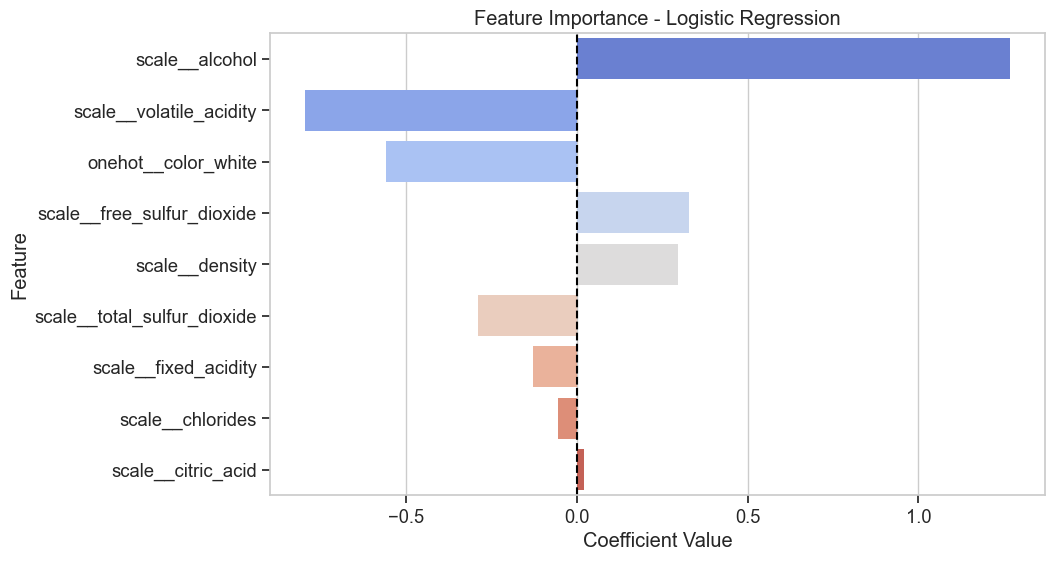

In [10]:
feature_importance = log_reg.coef_[0]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.show()

In [11]:
def save_model_results(model, y_true, x, results_dict, model_name):
    y_pred = model.predict(x)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    if model_name in results_dict:
        print("Dictionary already contains this model. Select another model_name")
        return results_dict
        
    results_dict[model_name] = {'accuracy':accuracy, 'confusion_matrix':cm,'model':model,'f1_score':f1, 'recall':recall}
    return results_dict


def plot_model_results(model, y_true, X, results_dict, model_name, n_bins=10):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{model_name} Model")
    # ------------------------------------------------------------------------
    # 1) Left subplot: Confusion Matrix
    # ------------------------------------------------------------------------
    cm = results_dict[model_name]['confusion_matrix']
    recall = results_dict[model_name]['recall']

    sns.heatmap(results_dict[model_name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar = False, xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"], ax=axes[0])
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Real")
    axes[0].set_title(f"Confusion Matrix. Recall={recall:.4f}")
    

    # ------------------------------------------------------------------------
    # 2) Right subplot:Predict_proba accuracy
    # ------------------------------------------------------------------------
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    # Probabilidades para acurácia por bin
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2.0
    bin_indices = np.digitize(y_prob, bins) - 1

    bin_counts = []
    bin_accuracies = []

    for i in range(n_bins):
        mask = (bin_indices == i)
        bin_count = np.sum(mask)
        if bin_count > 0:
            correct_count = np.sum(y_true[mask] == y_pred[mask])
            bin_accuracy = correct_count / bin_count
        else:
            bin_accuracy = 0.0
        bin_counts.append(bin_count)
        bin_accuracies.append(bin_accuracy)

    # Cores da paleta
    bar_color = palette[0]
    line_color = palette[1]

    # Histograma com seaborn
    sns.histplot(y_prob, bins=bins, ax=axes[1], color=bar_color, alpha=0.6, label='Count')
    axes[1].set_xlabel("Predicted Probability (positive class)")
    axes[1].set_ylabel("Count of samples in each bin", color='black')
    axes[1].tick_params(axis='y', colors='black')

    # Segundo eixo: linha de acurácia
    ax2 = axes[1].twinx()
    ax2.plot(bin_centers, bin_accuracies, marker='o', color=line_color, label='Accuracy')

    for x, y in zip(bin_centers, bin_accuracies):
        ax2.text(x, y + 0.03, f"{y*100:.0f}%", ha='center', va='bottom', color=line_color, fontsize=12, fontweight = 'bold')

    ax2.set_ylabel("")
    ax2.set_yticks([])
    ax2.tick_params(axis='y', colors=line_color)
    ax2.set_ylim([0, 1.1])
    axes[1].set_title("Probability Distribution & Accuracy by Bin")

    # Juntando legendas de ambos os eixos
    handles1, labels1 = axes[1].get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    axes[1].legend(handles1 + handles2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"../images/{model_name}_performance.png", dpi=300)
    plt.show()

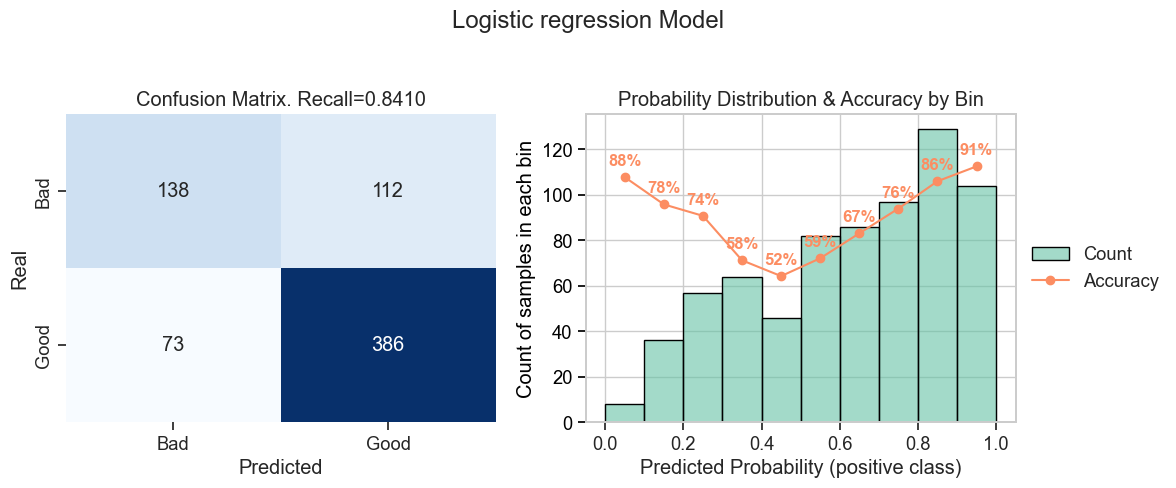

In [12]:
results_dict = {}
results_dict = save_model_results(log_reg, y_valid, X_valid, results_dict, 'Logistic regression')
plot_model_results(log_reg, y_valid, X_valid, results_dict, 'Logistic regression')

### 3.2 - Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predições no conjunto de validação
y_pred = rf.predict(X_valid)

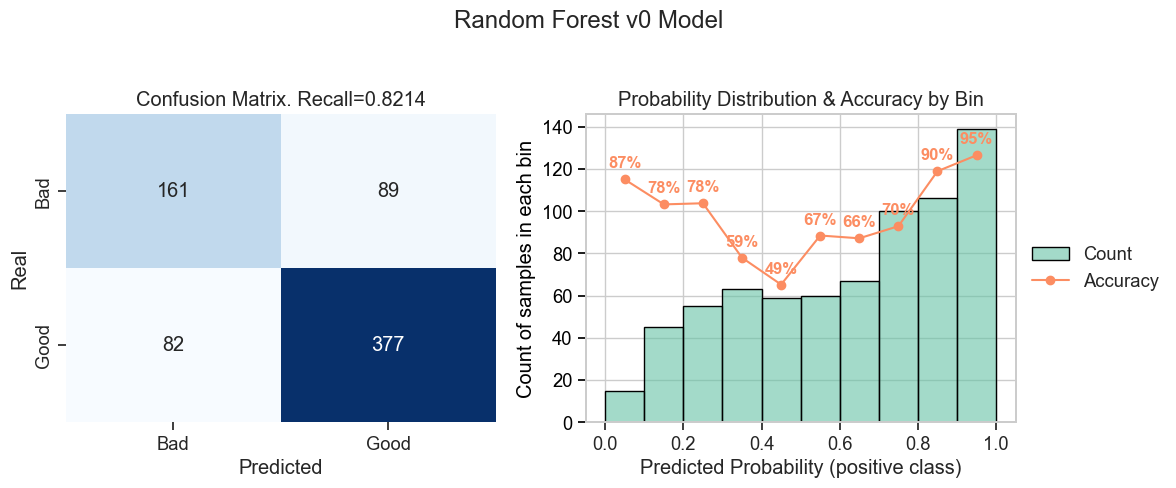

In [14]:
results_dict = save_model_results(rf, y_valid, X_valid, results_dict, 'Random Forest v0')
plot_model_results(rf, y_valid, X_valid, results_dict, 'Random Forest v0')

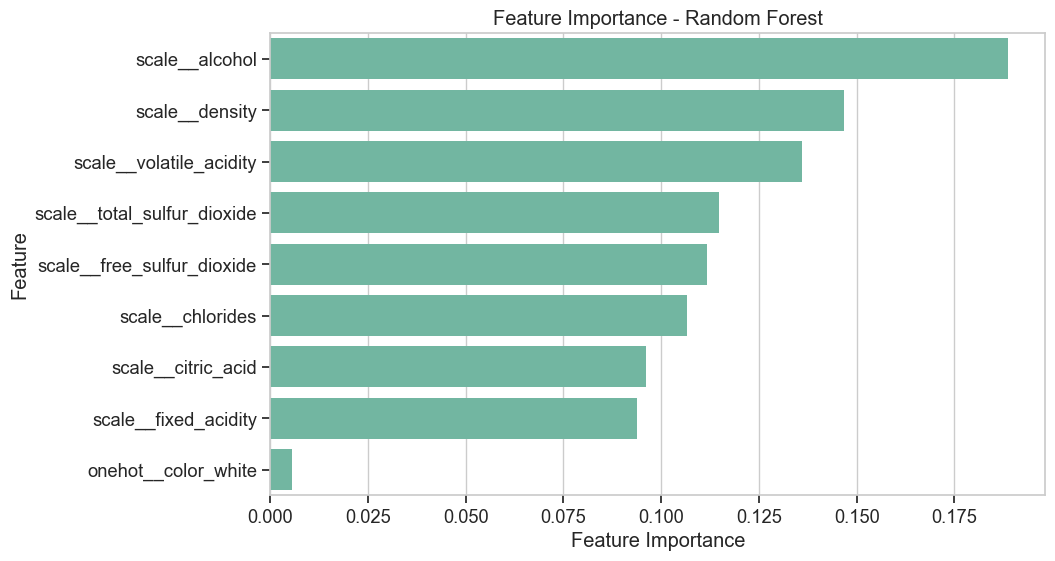

In [15]:
# Importância das features
feature_importance = rf.feature_importances_

# Criando DataFrame para visualização
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotando a importância das features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.show()

### 3.2.2 Hyperparameter tunning

In [16]:
param_grid = {
    'n_estimators': [20, 100, 200, 500],
    'max_depth': [None, 5, 10,30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

rf_base = RandomForestClassifier(random_state=42)

# Criar a busca aleatória com RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1,
    random_state=42
)

# Treinar a busca de hiperparâmetros
rf_search.fit(X_train, y_train)

print("Best model parameters:", rf_search.best_params_)

# Treinar o modelo final com os melhores hiperparâmetros
best_rf = rf_search.best_estimator_

Best model parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 50, 'class_weight': None}


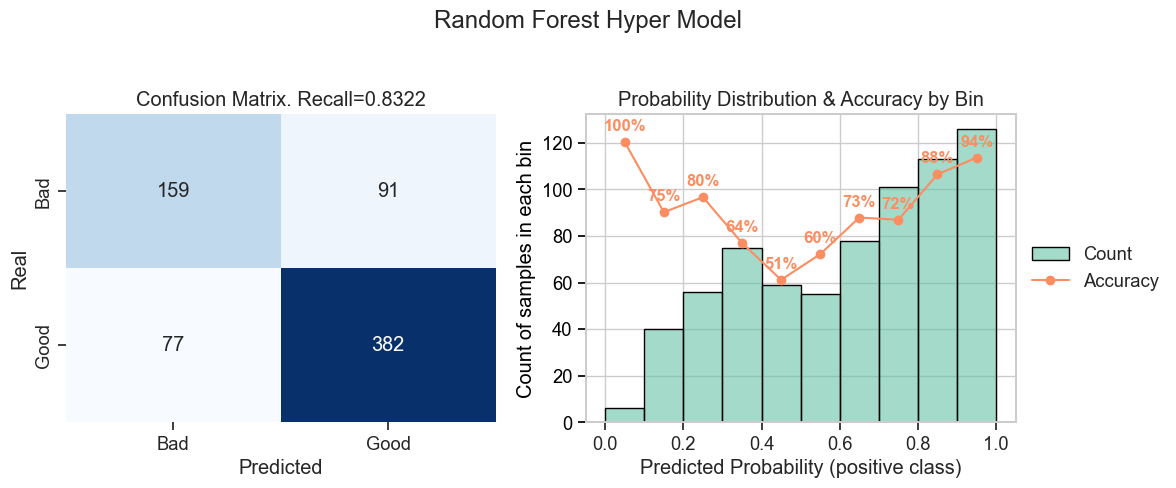

In [17]:
results_dict = save_model_results(best_rf, y_valid, X_valid, results_dict, 'Random Forest Hyper')
plot_model_results(best_rf, y_valid, X_valid, results_dict, 'Random Forest Hyper')

### 3.3 SVC

In [18]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

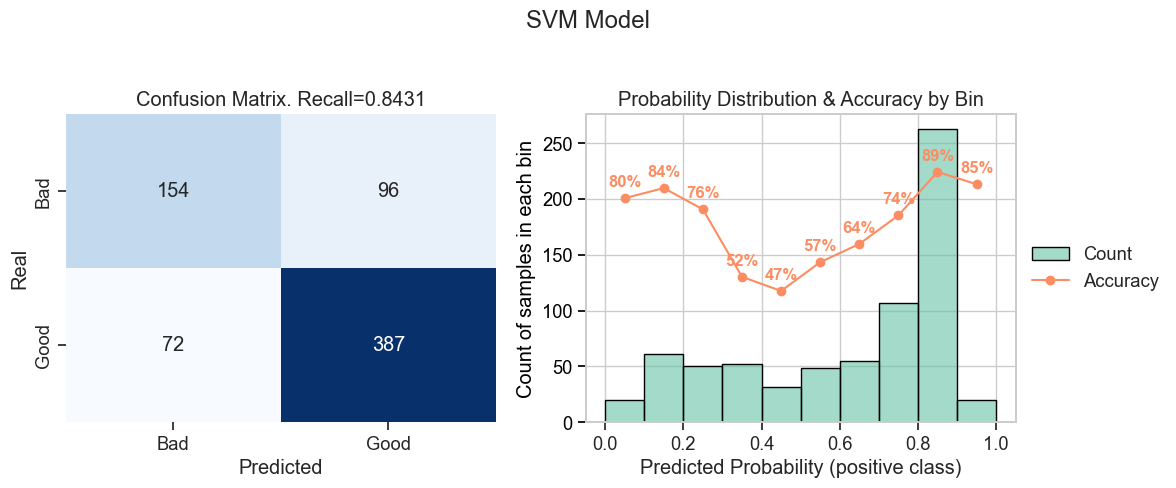

In [19]:
results_dict = save_model_results(svm_model, y_valid, X_valid, results_dict, 'SVM')
plot_model_results(svm_model, y_valid, X_valid, results_dict, 'SVM')

### 3.4 XGBoost

In [20]:
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

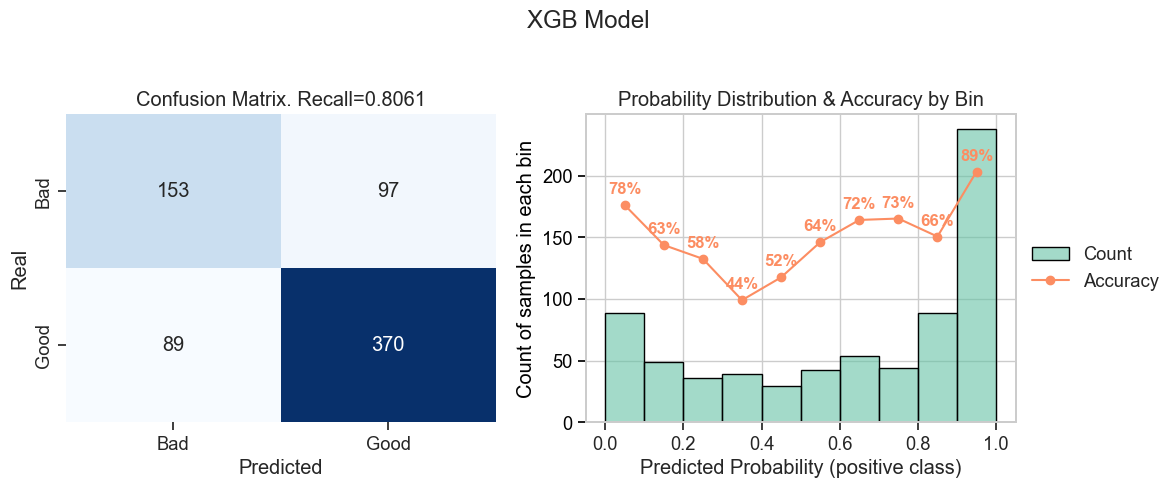

In [21]:
results_dict = save_model_results(xgb_model, y_valid, X_valid, results_dict, 'XGB')
plot_model_results(xgb_model, y_valid, X_valid, results_dict, 'XGB')

### 3.4.2 Hyperparameter tunning

In [22]:
# 1. Define o modelo base
xgb = XGBClassifier(
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# 2. Espaço de busca dos hiperparâmetros
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 5, 10]
}

# 3. Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. RandomizedSearch
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter = 20,  # você pode aumentar pra 50 ou 100 se quiser explorar mais
    scoring=f2_scorer,
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# 5. Treinando nos dados originais (sem polynomial, sem feat eng)
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=1)

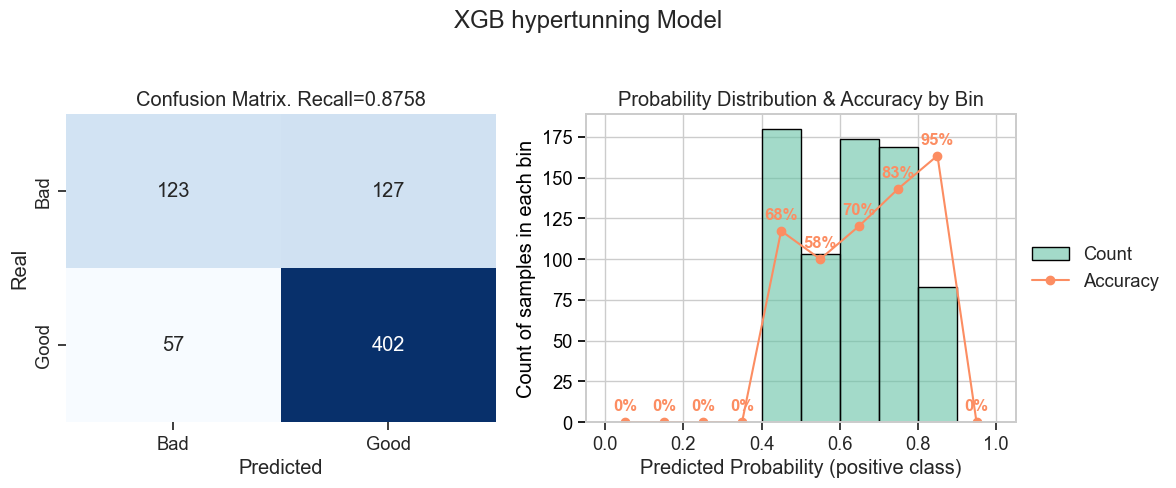

In [23]:
best_xgb = random_search_xgb.best_estimator_

results_dict = save_model_results(best_xgb, y_valid, X_valid, results_dict, 'XGB hypertunning')
plot_model_results(best_xgb, y_valid, X_valid, results_dict, 'XGB hypertunning')

## 4 - Enhancing performance

### 4.1 - Feature Engineering and Feature Selection

In [27]:
def add_ratio_feature(X, feature_names, 
                      numerator_name='free_sulfur_dioxide', 
                      denominator_name='total_sulfur_dioxide', 
                      new_col_name='sulfur_ratio'):
    """
    Adds a new column = X[:, idx_numerator] / X[:, idx_denominator].
    Returns (X_new, updated_feature_names).
    
    Parameters
    ----------
    X : numpy.ndarray
        2D array of shape (n_samples, n_features).
    feature_names : list of str
        Names of columns in the same order as X.
    numerator_name : str
        Name of the feature that will be the numerator in the ratio.
    denominator_name : str
        Name of the feature that will be the denominator in the ratio.
    new_col_name : str
        The name for the newly created ratio feature.
    """
    if not isinstance(feature_names, list):
        feature_names = feature_names.tolist()

    idx_num = feature_names.index(numerator_name)
    idx_den = feature_names.index(denominator_name)
    
    ratio = X[:, idx_num] / (X[:, idx_den] + 1e-9)
    ratio = ratio.reshape(-1, 1)  # make it a column vector
    
    X_new = np.hstack([X, ratio])
    
    updated_feature_names = feature_names + [new_col_name]
    
    return X_new, updated_feature_names

In [30]:
#Added ratios features
X_train_ext, feature_names_ext = X_train, feature_names
X_valid_ext = X_valid

# Lista de ratios a adicionar
ratios_to_add = [
    ('scale__free_sulfur_dioxide', 'scale__total_sulfur_dioxide', 'sulfur_ratio'),
    ('scale__citric_acid', 'scale__volatile_acidity', 'acid_ratio'),
    ('scale__chlorides', 'scale__alcohol', 'chloride_alcohol_ratio'),
]

# Aplica todos os ratios de forma sequencial
for num, den, name in ratios_to_add:
    X_train_ext, feature_names_ext = add_ratio_feature(X_train_ext, feature_names_ext, num, den, name)
    X_valid_ext, _ = add_ratio_feature(X_valid_ext, feature_names_ext, num, den, name)

In [31]:
xgb_base = XGBClassifier(
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)


random_search_xgb_fe = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,  # você pode aumentar pra 50 ou 100 se quiser explorar mais
    scoring=f2_scorer,
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# 5. Treinando nos dados originais (sem polynomial, sem feat eng)
random_search_xgb_fe.fit(X_train_ext, y_train)

print("Best model parameters:", random_search_xgb_fe.best_params_)
best_xgb_fe = random_search_xgb_fe.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best model parameters: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}


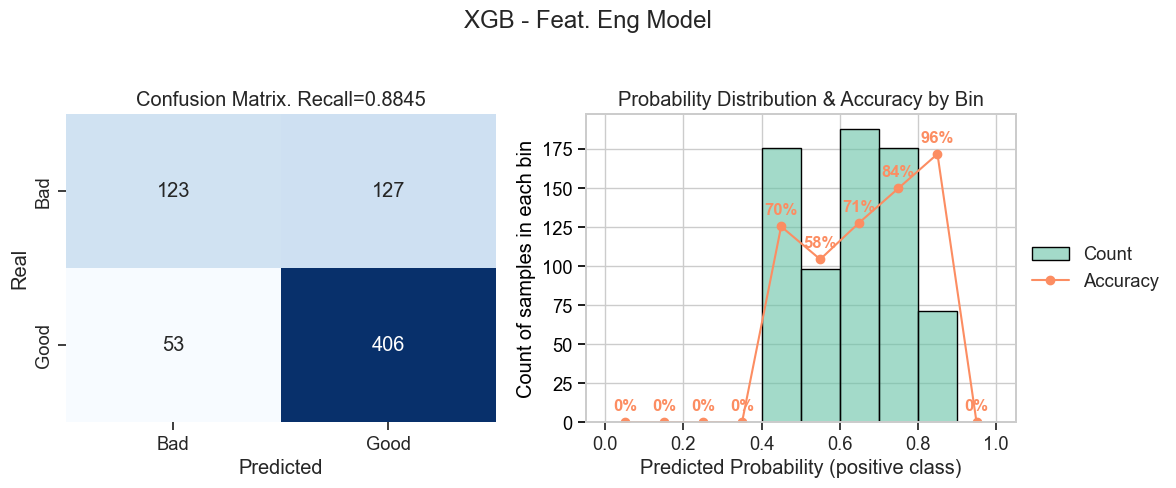

In [32]:
results_dict = save_model_results(best_xgb_fe, y_valid, X_valid_ext, results_dict, 'XGB - Feat. Eng')
plot_model_results(best_xgb_fe, y_valid, X_valid_ext, results_dict, 'XGB - Feat. Eng')

In [33]:
if not isinstance(feature_names, list):
    feature_names = feature_names.tolist()

cols_for_polynomial = feature_names.copy()
cols_for_polynomial.remove('onehot__color_white')

poly_transformer = ColumnTransformer(
    transformers=[
        (
            'numeric_poly', 
            Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('poly', PolynomialFeatures(degree=2, include_bias=False)),
                ('scaler', StandardScaler())
            ]),
            cols_for_polynomial
        ),
        (
            'passthrough_binaria',
            'passthrough',
            ['onehot__color_white']
        )
    ]
)

# 3. Pipeline final (agora o ColumnTransformer cuida de tudo)
pipeline = Pipeline([
    ('poly_transformer', poly_transformer)
])

In [34]:
X_train_poly = pipeline.fit_transform(X_train_df)
X_valid_poly = pipeline.transform(X_valid_df)

In [35]:
random_search_xgb_poly = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring=f2_scorer,
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# 5. Treinando nos dados originais (sem polynomial, sem feat eng)
random_search_xgb_poly.fit(X_train_poly, y_train)

print("Best model parameters:", random_search_xgb_poly.best_params_)
best_xgb_poly = random_search_xgb_poly.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best model parameters: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}


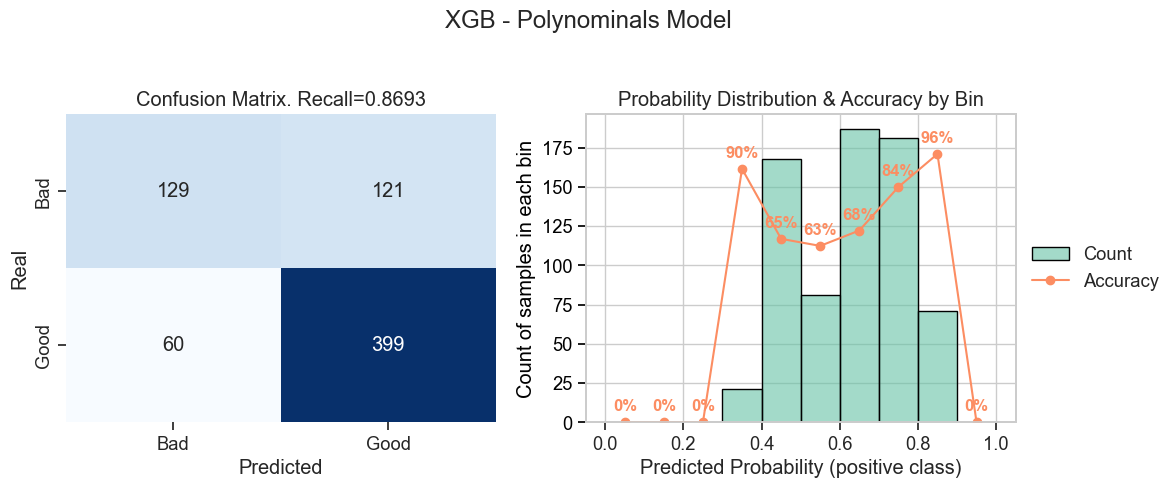

In [36]:
results_dict = save_model_results(best_xgb_poly, y_valid, X_valid_poly, results_dict, 'XGB - Polynominals')
plot_model_results(best_xgb_poly, y_valid, X_valid_poly, results_dict, 'XGB - Polynominals')

C:\Users\giode\AppData\Local\Temp\ipykernel_13088\3248946119.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


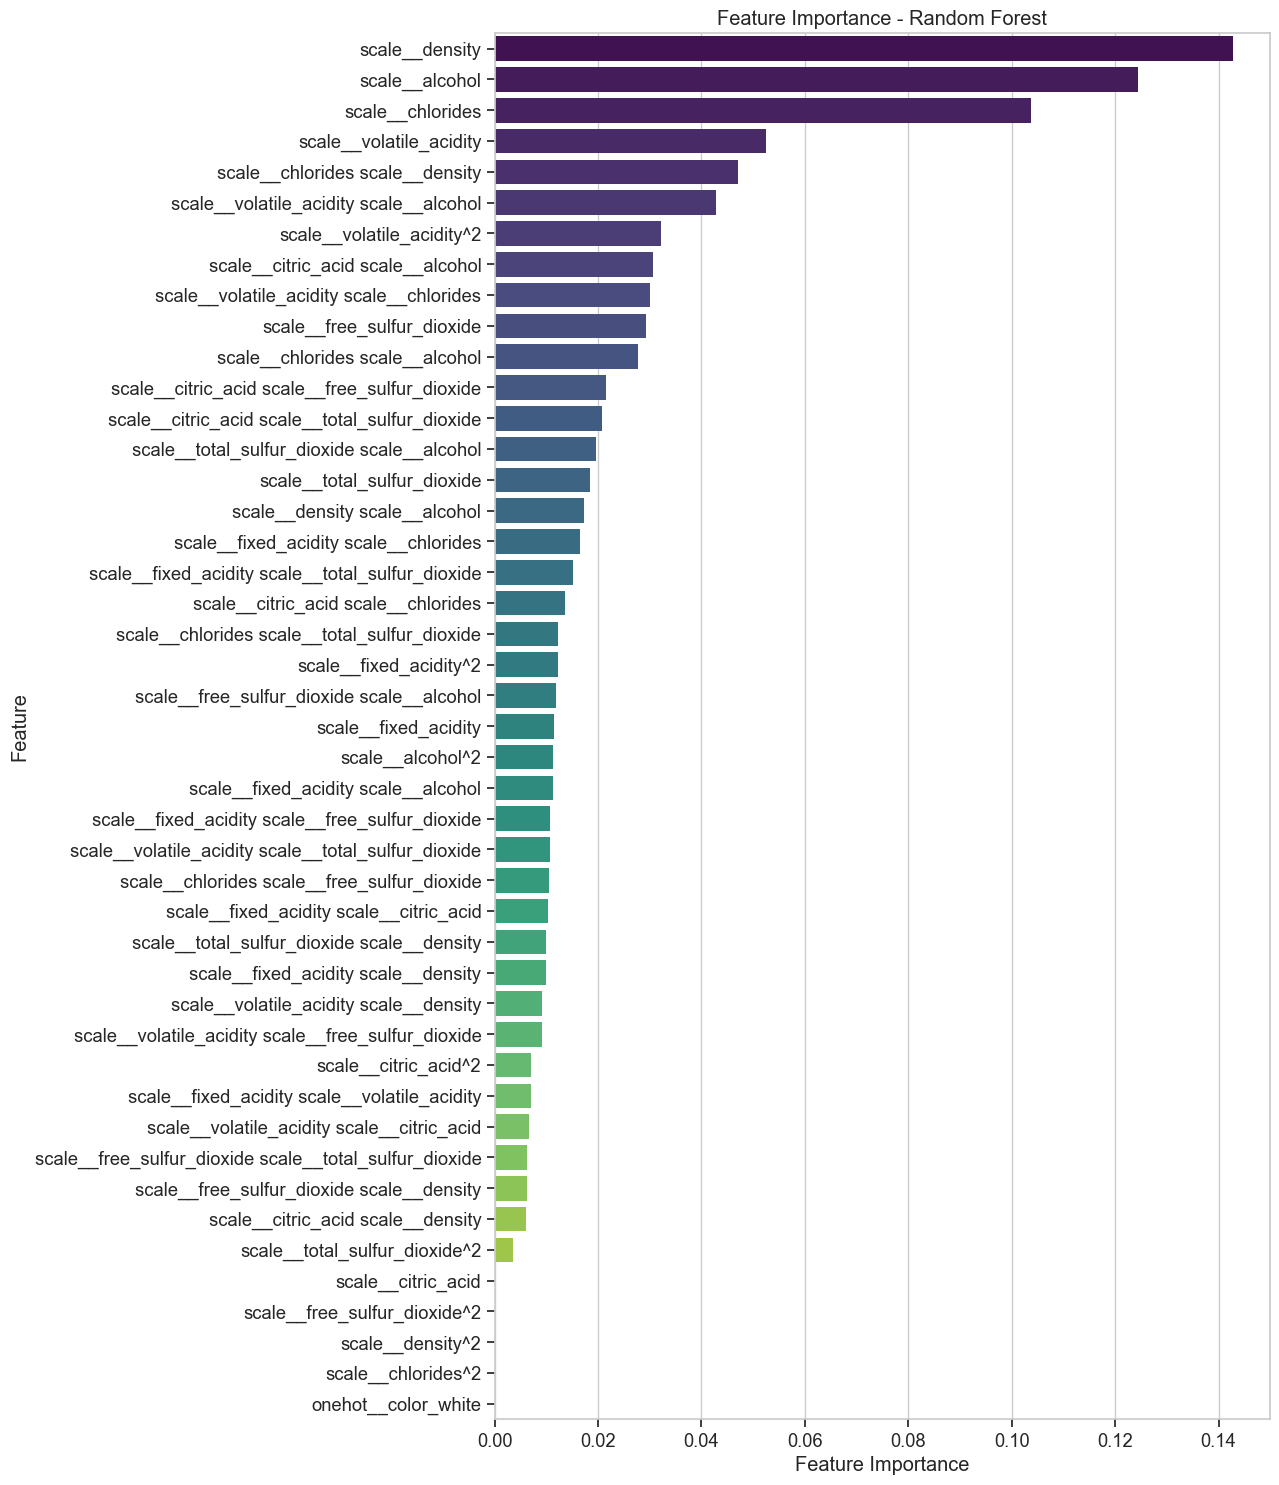

In [37]:
column_transformer = pipeline.named_steps['poly_transformer']
numeric_pipeline = column_transformer.named_transformers_['numeric_poly']
poly_feature_names = numeric_pipeline.named_steps['poly'].get_feature_names_out(cols_for_polynomial)
final_feature_names = list(poly_feature_names) + ['onehot__color_white']

feature_importance = best_xgb_poly.feature_importances_

importance_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,18))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.show()

In [38]:
def feature_selection_via_random(X_train, X_valid,y_train, y_valid, feature_names, max_rounds=10, model_params=None, verbose=True):
    
    X_train_fs = X_train.copy()
    X_valid_fs = X_valid.copy()
    feature_names_fs = feature_names.copy()
    history = []

    for round_num in range(1, max_rounds + 1):
        if verbose:
            print(f"Round {round_num} — {len(feature_names_fs)} features")

        # 1. Adiciona coluna de ruído aleatório
        np.random.seed(round_num)
        random_col_train = np.random.rand(X_train_fs.shape[0], 1)
        random_col_valid = np.random.rand(X_valid_fs.shape[0], 1)

        X_train_aug = np.hstack([X_train_fs, random_col_train])
        X_valid_aug = np.hstack([X_valid_fs, random_col_valid])
        feature_names_aug = feature_names_fs + ['random_noise']

        # 2. Treina o modelo
        model = XGBClassifier(**(model_params or {}))
        model.fit(X_train_aug, y_train)

        # 3. Avalia performance
        y_pred = model.predict(X_valid_aug)
        recall = recall_score(y_valid, y_pred)
        acc = accuracy_score(y_valid, y_pred)

        # 4. Coleta importâncias
        importances = model.feature_importances_
        random_importance = importances[-1]

        importance_df = pd.DataFrame({
            'Feature': feature_names_aug,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        if verbose:
            print(f"Accuracy: {acc:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"Random noise importance: {random_importance:.6f}")
            print(f"Dropping {sum(importance_df['Importance'] < random_importance)} feature(s)")

        # 5. Remove features menos importantes que a random
        keep_mask = importances[:-1] >= random_importance
        if not np.any(keep_mask):
            if verbose:
                print("No features above random noise — stopping early.")
            break

        X_train_fs = X_train_fs[:, keep_mask]
        X_valid_fs = X_valid_fs[:, keep_mask]
        feature_names_fs = [f for i, f in enumerate(feature_names_fs) if keep_mask[i]]

        # 6. Salva histórico
        history.append({
            'round': round_num,
            'accuracy': acc,
            'recall': recall,
            'random_importance': random_importance,
            'num_features': len(feature_names_fs),
            'kept_features': feature_names_fs.copy(),
        })

    return history, X_train_fs, X_valid_fs, feature_names_fs


In [39]:
history, X_train_fs, X_valid_fs, feature_names_fs = feature_selection_via_random(
    X_train_poly, X_valid_poly,
    y_train, y_valid,
    feature_names=final_feature_names,   # nomes gerados do pipeline
    max_rounds=200,
    model_params = best_xgb_poly.get_params(),
    verbose=False
)

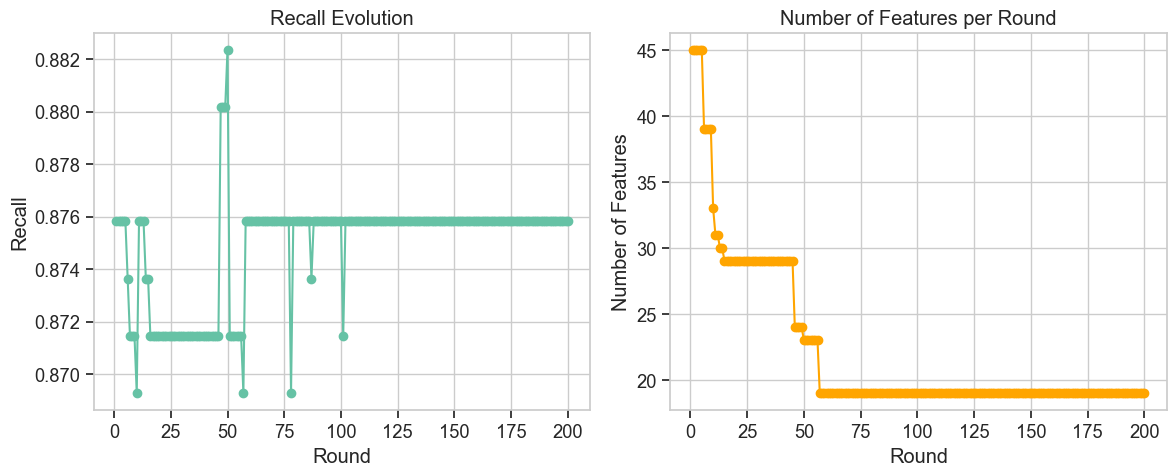

In [40]:
rounds = [h['round'] for h in history]
recalls = [h['recall'] for h in history]
num_feats = [h['num_features'] for h in history]

# Criando a figura
plt.figure(figsize=(12, 5))

# Evolução do Recall
plt.subplot(1, 2, 1)
plt.plot(rounds, recalls, marker='o')
plt.title('Recall Evolution')
plt.xlabel('Round')
plt.ylabel('Recall')
plt.grid(True)

# Evolução do número de features
plt.subplot(1, 2, 2)
plt.plot(rounds, num_feats, marker='o', color='orange')
plt.title('Number of Features per Round')
plt.xlabel('Round')
plt.ylabel('Number of Features')
plt.grid(True)

plt.tight_layout()
plt.show()

### 4.2 Balancing the dataset

In [41]:
X_train_bal = X_train
y_train_bal = y_train

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_bal, y_train_bal)

print("After SMOTE:")
print("Shape X:", X_train_bal.shape)
print("Class distribution:", pd.Series(y_train_bal).value_counts())

After SMOTE:
Shape X: (5316, 9)
Class distribution: quality_categorical
1    2658
0    2658
Name: count, dtype: int64


In [53]:
# Initialize the XGBoost model
xgb_base = XGBClassifier(random_state=42)

# Create the RandomizedSearchCV with XGBoost
xgb_search_balanced = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring=f2_scorer,  # Make sure you have f2_scorer defined
    n_jobs=-1,
    random_state=42
)

# Train the model using RandomizedSearchCV
xgb_search_balanced.fit(X_train_bal, y_train_bal)

# Print the best parameters found by the search
print("Best model parameters:", xgb_search_balanced.best_params_)

# Train the final model using the best parameters
best_xgb_balanced = xgb_search_balanced.best_estimator_

C:\Users\giode\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [15:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Best model parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'class_weight': 'balanced'}


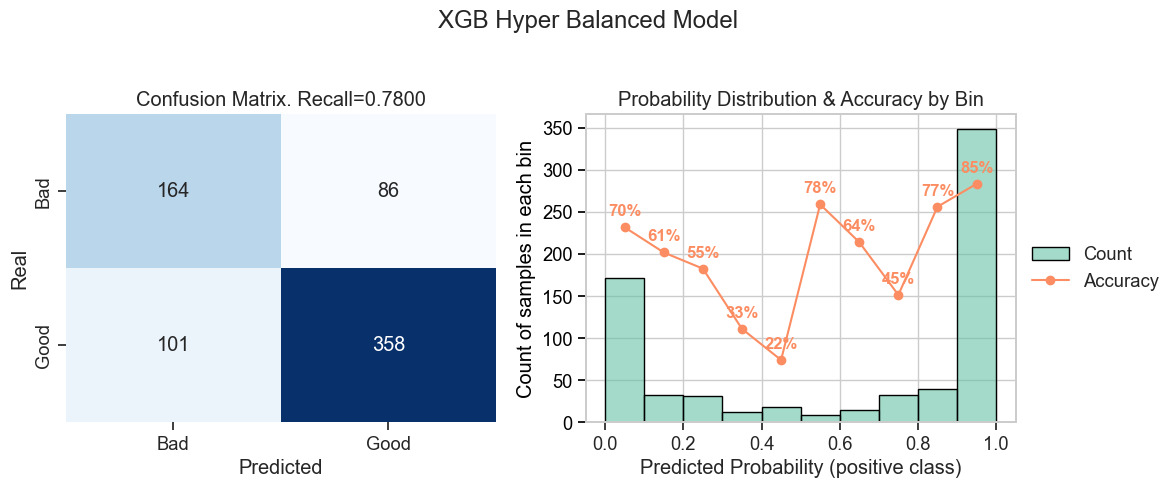

In [54]:
results_dict = save_model_results(best_xgb_balanced, y_valid, X_valid, results_dict, 'XGB Hyper Balanced')
plot_model_results(best_xgb_balanced, y_valid, X_valid, results_dict, 'XGB Hyper Balanced')

## 5 - Selection a model

In [44]:
# Extração dos dados
model_names = list(results_dict.keys())
recall_scores = [results_dict[model]['recall'] for model in model_names]
accuracy_scores = [results_dict[model]['accuracy'] for model in model_names]
# Identifica o melhor modelo
best_index = recall_scores.index(max(recall_scores))
best_model_name = model_names[best_index]
best_recall_score = recall_scores[best_index]

best_recall_model = results_dict[best_model_name]['model']

In [45]:
model_table = pd.DataFrame({'model_names':model_names, 'recall':recall_scores, 'accuracy':accuracy_scores})
display(model_table)

,model_names,recall,accuracy
0,Logistic regression,0.840959,0.739069
1,Random Forest v0,0.821351,0.758815
2,Random Forest Hyper,0.832244,0.763047
3,SVM,0.843137,0.763047
4,XGB,0.806100,0.737659
5,XGB hypertunning,0.875817,0.740480
6,XGB - Feat. Eng,0.884532,0.746121
7,XGB - Polynominals,0.869281,0.744711
8,Random Forest Hyper Balanced,0.771242,0.748942


In [46]:
len(recall_scores)

9

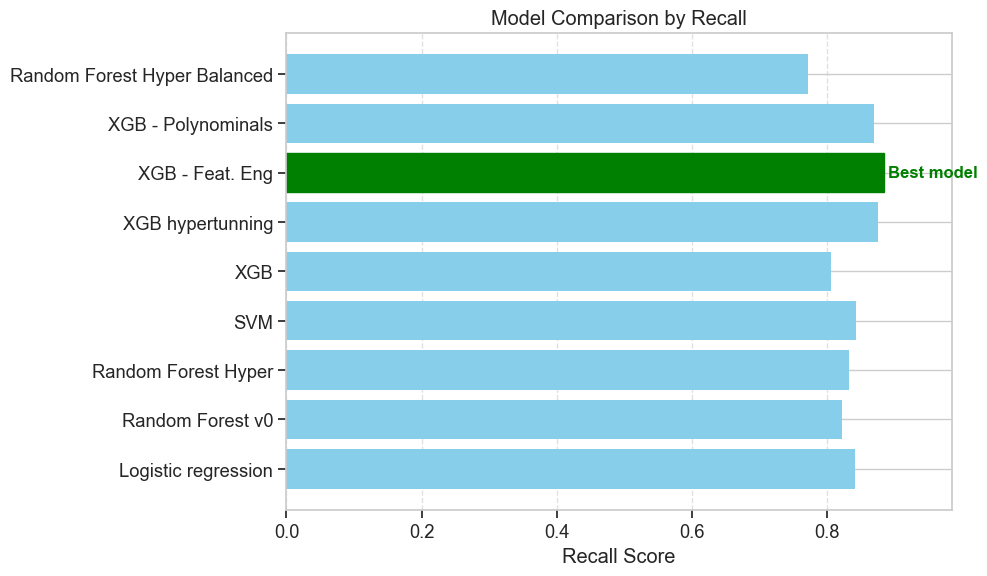

In [47]:
# Criação do gráfico horizontal
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, recall_scores, color='skyblue')

# Destaca o melhor modelo
bars[best_index].set_color('green')
plt.text(best_recall_score + 0.005, best_index, 'Best model', 
         va='center', fontsize=12, fontweight='bold', color='green')

# Estética do gráfico
plt.xlabel('Recall Score')
plt.title('Model Comparison by Recall')
plt.xlim(0, max(recall_scores) + 0.1)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 5.2 Feature Selection for the Best Model

In [48]:
history_best, X_train_best, X_valid_best, feature_names_best = feature_selection_via_random(
    X_train, X_valid,
    y_train, y_valid,
    feature_names=feature_names,   # nomes gerados do pipeline
    max_rounds=300,
    model_params = best_recall_model.get_params(),
    verbose=False
)

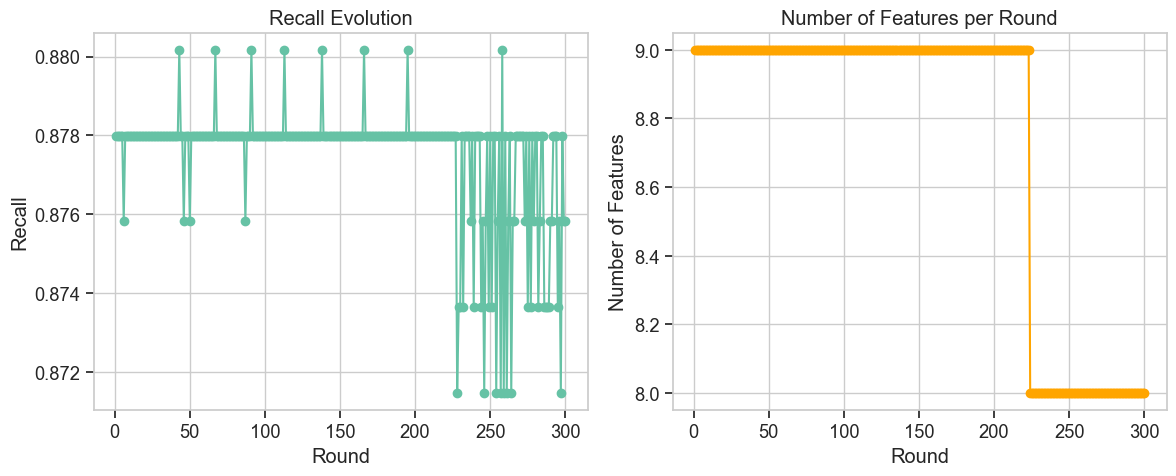

In [49]:
rounds = [h['round'] for h in history_best]
recalls = [h['recall'] for h in history_best]
num_feats = [h['num_features'] for h in history_best]

# Criando a figura
plt.figure(figsize=(12, 5))

# Evolução do Recall
plt.subplot(1, 2, 1)
plt.plot(rounds, recalls, marker='o')
plt.title('Recall Evolution')
plt.xlabel('Round')
plt.ylabel('Recall')
plt.grid(True)

# Evolução do número de features
plt.subplot(1, 2, 2)
plt.plot(rounds, num_feats, marker='o', color='orange')
plt.title('Number of Features per Round')
plt.xlabel('Round')
plt.ylabel('Number of Features')
plt.grid(True)

plt.tight_layout()
plt.show()

Our best performance achieved was using all features

In [50]:
print(f"Dropped columns: {set(feature_names).difference(set(history_best[50]['kept_features']))}")

Dropped columns: set()


## 6 - Evaluating model performance on test sample

In [55]:
feature_names

['onehot__color_white',
 'scale__fixed_acidity',
 'scale__volatile_acidity',
 'scale__citric_acid',
 'scale__chlorides',
 'scale__free_sulfur_dioxide',
 'scale__total_sulfur_dioxide',
 'scale__density',
 'scale__alcohol']

### 6.1 Hyperparameter tunning

In [57]:
# Modelo base
xgb = XGBClassifier(
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

param_dist_refined = {
    'n_estimators': [80, 100, 120, 150],
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_xgb_refined = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_refined,
    n_iter=150,
    scoring=f2_scorer,
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Treina o modelo
random_search_xgb_refined.fit(X_train, y_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.02, 0.05],
                                        'max_depth': [4, 5, 6, 7],
                                        'n_estimators': [80, 100, 120, 150],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=1)

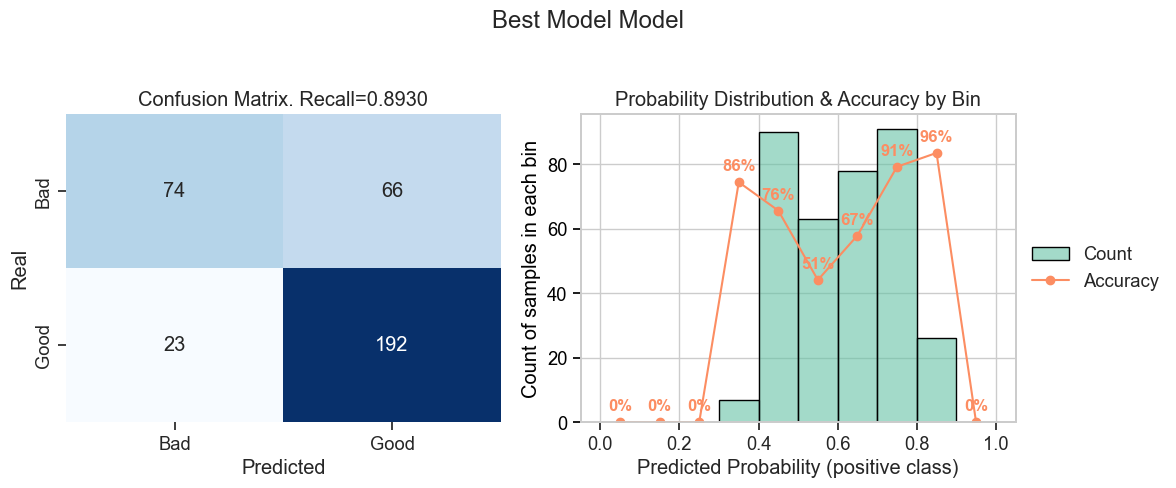

In [59]:
y_pred_test = random_search_xgb_refined.predict(X_test)

results_dict = save_model_results(random_search_xgb_refined, y_test, X_test, results_dict, 'Best Model')
plot_model_results(random_search_xgb_refined, y_test, X_test, results_dict, 'Best Model')

## 7 - Model Simulation for Prediction Wine Quality Profit
- We will simulate a profit scenário, where when we buy a good wine we profit $\$10.00$, but when we buy a bad wine we lose $\$5.00$ (we can sell it with discount
- Then, we will try to generalize for different profits and losses.

In [60]:
# Baseline model -> Purchase everything
profit= y_test.sum()*10 + (y_test-1).sum()*5

In [61]:
profit_model = 0

for pred, true in zip(y_pred_test, y_test):
    if pred == 1:
        if true == 1:
            profit_model+=10
        else:
            profit_model-=5

In [62]:
print(f"Profit using a baseline strategy (buy everythin): ${profit:.2f}\n Profit using a machine learning strategy: ${profit_model:.2f}")

Profit using a baseline strategy (buy everythin): $1450.00
 Profit using a machine learning strategy: $1590.00


In [63]:
n_profit = 100
n_lost = 100
profit_price = np.linspace(1,20,n_profit)
lost_price = np.linspace(1,20,n_lost)

In [64]:
profit_difference = np.zeros((n_profit,n_lost))

In [65]:
for i in range(n_profit):
    for j in range(n_lost):
        profit_baseline= y_test.sum()*profit_price[i] + (y_test-1).sum()*lost_price[j]
        profit_model = 0

        for pred, true in zip(y_pred_test, y_test):
            if pred == 1:
                if true == 1:
                    profit_model+=profit_price[i]
                else:
                    profit_model-=lost_price[j]
        profit_difference[i,j] = (profit_model - profit_baseline)

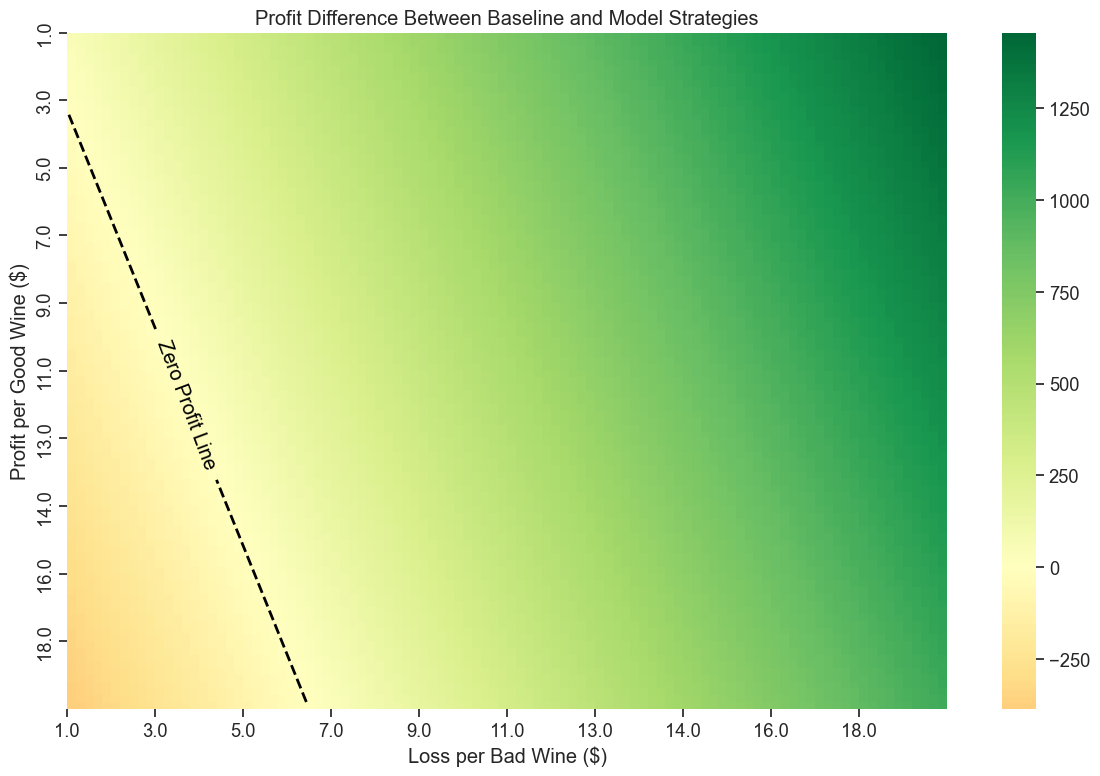

In [66]:
plt.figure(figsize=(12, 8))
sns.heatmap(profit_difference,
            cmap="RdYlGn", center=0,
            xticklabels=5, yticklabels=5)  # mostra 1 a cada 5 ticks

# título e eixos
plt.title("Profit Difference Between Baseline and Model Strategies")
plt.xlabel("Loss per Bad Wine ($)")
plt.ylabel("Profit per Good Wine ($)")

# linha de zero lucro
contour = plt.contour(profit_difference, levels=[0], colors='black', linewidths=2, linestyles='--')
plt.clabel(contour, fmt='Zero Profit Line', colors='black')

tick_step = 10
plt.xticks(ticks=np.arange(0, len(lost_price), tick_step),
           labels=np.round(lost_price[::tick_step], 0))
plt.yticks(ticks=np.arange(0, len(profit_price), tick_step),
           labels=np.round(profit_price[::tick_step], 0))

plt.tight_layout()
plt.savefig("../images/profit_difference_plot.png", dpi=300)
plt.show()

## 8 - Conclusion

In this project, we developed a machine learning model to predict whether a wine is **good** or **bad** based on its physicochemical features (e.g., alcohol content, acidity, etc.).

- The best-performing model was **XGBoost**, selected after testing and comparing multiple algorithms.
- We chose to optimize for the **F-beta score** with **beta = 2**, giving **twice as much importance to recall** over precision. This decision was made because **missing a good wine (false negative)** is more costly than **buying a bad one (false positive)** in our scenario.

### Profit Simulation

We simulated a profit scenario to understand the real-world impact of our model:

- **\$10.00 profit** when buying a good wine (true positive).
- **\$5.00 loss** when buying a bad wine (false positive), assuming it’s sold at a discount.

In this specific setup, our model generated **7% more profit** than the baseline strategy (which assumes buying all wines), demonstrating strong business value.

We also generalized this by creating a simulation across multiple profit and loss combinations (ranging from \$1 to \$20). From this grid search:

- The model tends to bring **even more profit when the profit is lower or the loss is higher**, which could inform risk-based pricing strategies.

### Model Performance

Our model achieved the following performance:

- **Recall**: 0.8930

We also observed that the model’s **accuracy is lowest in the 50% predicted probability bin**, which is expected, since those are the most uncertain cases. This suggests our model is reliable at the extremes (very confident predictions) but less so around the threshold — a common and acceptable pattern.

### Next Steps

- Use **real historical sales and loss data** to calibrate the profit simulation with business-specific values.
- Explore different **classification thresholds** (instead of the default 0.5) to **optimize for profit**, not just standard metrics.
- Consider **probability calibration techniques** to improve decision-making, especially for predictions near the 50% range.
